In [5]:
# Import packages
import pandas as pd       
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt 
import numpy as np
import xgboost as xgb
import pickle

In [6]:
# import data
data = pd.read_csv('../../data/datasetlabel.csv')
data['date'] = pd.to_datetime(data['date'])

# load selected features with pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

In [7]:
start_date = pd.to_datetime('2008-01-01')
end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
training_features = selected_features[start_date]

# print the features
print(f'Training features:\n{training_features}')

X = training_data[training_features].copy()
y = training_data['target'].copy()
negative_mask = (y == -1)
y[negative_mask] = 0

Training features:
['CAPEI', 'equity_invcap', 'evm', 'pe_op_basic', 'pe_inc', 'ps', 'ptpm', 'roa', 'roe', 'aftret_equity', 'aftret_invcapx', 'GProf', 'capital_ratio', 'short_debt', 'fcf_ocf', 'lt_ppent', 'at_turn', 'rect_turn', 'pay_turn', 'adv_sale', 'stat_divyeld', 'prc', 'vol', 'retx', 'mktcap', 'MACD_index']


In [9]:
# import the model with pickle
n_estimators = 150
model_name = f'xg_boost_{start_date}_{n_estimators}.pkl'
with open(f'../../models/{model_name}', 'rb') as f:
    model = pickle.load(f)

In [10]:
first_trading_date = start_date + pd.DateOffset(years=2)
dates = data['date'].unique()

# find the first trading day after the end date
while first_trading_date not in dates:
    first_trading_date += pd.DateOffset(days=1)

print(f'First trading date: {first_trading_date}')

X_prediction_mask = data['date'] == first_trading_date
X_prediction = data[X_prediction_mask][training_features].copy()

assert len(X_prediction) > 0, 'No data to predict'
permnos_first_trading_day = data[X_prediction_mask]['permno'].copy()
target = data[X_prediction_mask]['target'].copy()
target[target == -1] = 0

First trading date: 2010-01-04 00:00:00


In [11]:
return_date = first_trading_date + pd.DateOffset(days=90)

# find the first trading day after the end date
while return_date not in dates:
    return_date -= pd.DateOffset(days=1)

print(f'Return date: {return_date}')

X_return_mask = data['date'] == return_date

# calculate 90 days return
trading_day_price = data[X_prediction_mask]['prc'].copy()
return_day_price = data[X_return_mask]['prc'].copy()
permnos_return = data[X_return_mask]['permno'].copy()

Return date: 2010-04-01 00:00:00


In [12]:
# find the predictions
y_pred_proba = model.predict_proba(X_prediction)
y_pred = model.predict(X_prediction)

# check if prediction is correct
correct_prediction = y_pred == target

# put the predictions in a dataframe
predictions_df = pd.DataFrame({
    'permno': permnos_first_trading_day,
    '0_probability': y_pred_proba[:, 0],
    '1_probability': y_pred_proba[:, 1],
    'prediction': y_pred,
    'correct_prediction': correct_prediction,
    'trading_day_price': trading_day_price,
})

return_price_df = pd.DataFrame({
    'permnos': permnos_return,
    'price_return': return_day_price,
})

# merge the two dataframes
merged_df = pd.merge(predictions_df, return_price_df, left_on='permno', right_on='permnos')

# calculate the return
merged_df['return(%)'] = (merged_df['price_return'] / merged_df['trading_day_price'] - 1)*100

In [13]:
n = 15
# find the n argmin and argmax
top_n = merged_df['1_probability'].nlargest(n)
bottom_n = merged_df['1_probability'].nsmallest(n)

features_to_print = ['permno','0_probability', '1_probability', 'correct_prediction', 'return(%)']

print(f'Top {n} long predictions:')
print(merged_df.loc[top_n.index][features_to_print])
print('-'*58)
print(f'Top {n} short predictions:')
print(merged_df.loc[bottom_n.index][features_to_print])

Top 15 long predictions:
     permno  0_probability  1_probability  correct_prediction  return(%)
176   39490       0.001171       0.998829                True  -0.406254
498   87137       0.001251       0.998749                True -12.224295
587   91233       0.004724       0.995276                True  -0.514481
405   79915       0.006021       0.993979                True   8.796349
569   90547       0.006400       0.993600                True  18.118306
576   90829       0.007664       0.992336                True  -0.047544
575   90808       0.007792       0.992208                True   6.535000
424   81774       0.008342       0.991658                True   5.465023
374   77606       0.008641       0.991359                True   2.519452
252   57817       0.008684       0.991316                True   8.496689
137   27422       0.009143       0.990857                True  54.228683
132   26382       0.009635       0.990365                True  25.579798
11    10909       0.010086

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

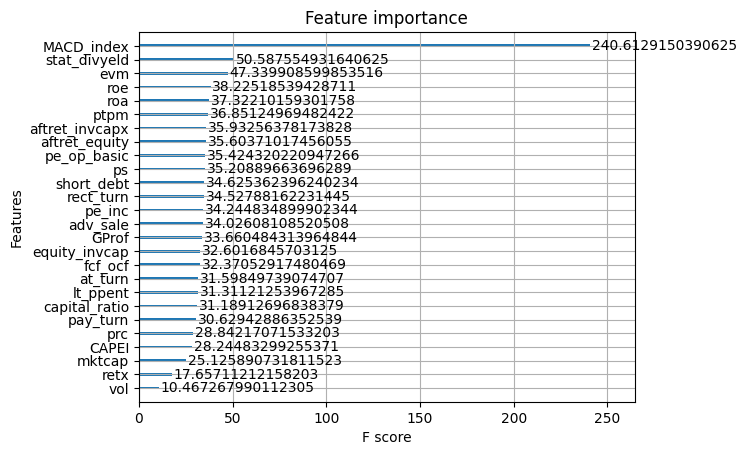

In [14]:
# gain is usually the most realiable metric to evaluate the importance of the features
xgb.plot_importance(model, importance_type='gain')